In [110]:
import torch.nn as nn
net = nn.Conv2d(64, 32, kernel_size=3, stride=2, padding=1)
d = torch.randn((10, 64, 2, 2))
net(d).shape

torch.Size([10, 32, 1, 1])

In [49]:
from torchvision.utils import save_image
import torch

d = torch.randn((100, 1, 28, 28))
save_image(d, 'results/1.png', nrow=10, normalize=True)

In [46]:
# -*- coding: utf-8 -*-
"""
Created on Fri May 15 09:26:17 2020
GAN生成minist数据
@author: 
"""

import torch
import torch.nn as nn
import numpy
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
image_size = 28*28
hidden_size = 256
latent_size = 128
epochs = 128
lr = 2e-4

#Discriminator
class D(nn.Module):
    def __init__(self, image_size, hidden_size):
        super(D, self).__init__()
        self.layer1 = nn.Linear(image_size, hidden_size)
        self.actF1 = nn.LeakyReLU(0.2)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, 1)
        self.actF2 = nn.Sigmoid() #二分类
        
    def forward(self, images):
        #image维度为[batch_size, image_size]
        x = self.layer1(images) #[batch_size, hidden_size]
        x = self.actF1(x) #[batch_size, hidden_size]
        x = self.layer2(x) #[batch_size, hidden_size]
        x = self.actF1(x) #[batch_size, hidden_size]
        x = self.layer3(x) #[batch_size, 1]
        y = self.actF2(x) #[batch_size, 1]
        return y

#Generator
class G(nn.Module):
    def __init__(self, latent_size, hidden_size, image_size):
        super(G, self).__init__()
        self.layer1 = nn.Linear(latent_size, hidden_size)
        self.actF1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, image_size)
        self.actF2 = nn.Tanh() #mnist是二值图，所以用tanh将生成图片的像素压在[0,1]间
        
    def forward(self, latents):
        #laten维度为[batch_size, laten_size]
        x = self.layer1(latents) #[batch_size, hidden_size]
        x = self.actF1(x) #[batch_size, hidden_size]
        x = self.layer2(x) #[batch_size, hidden_size]
        x = self.actF1(x) #[batch_size, hidden_size]
        x = self.layer3(x) #[batch_size, image_size]
        images = self.actF2(x) #[batch_size, image_size]
        return images
        


#图片预处理方法
transform = transforms.Compose([transforms.ToTensor()
                               ])
#下载mnist中的训练数据集，并对其预处理
mnist_data = torchvision.datasets.MNIST("./mnist",
                                        train=True,
                                        download=True,
                                        transform=transform)
#将预处理好的数据集处理成dataloader
dataloader = torch.utils.data.DataLoader(dataset=mnist_data,
                                         batch_size = batch_size,
                                         shuffle = True)

total_step = len(dataloader)
D = D(image_size, hidden_size).to(device)
G = G(latent_size, hidden_size, image_size).to(device)
loss_func = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr = lr)
g_optimizer = torch.optim.Adam(G.parameters(), lr = lr)

for epoch in range(epochs):
    for i, (images, _) in enumerate(dataloader):
        #当dataloader的数量不是batch_size的整数倍时，应将最后一个batch_size改为实际的大小
        batch_size = images.size(0)
        #[batch_size, 28, 28] -> [batch_size, 28*28]
        real_images = images.reshape(batch_size, image_size).to(device)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        #鉴别真实图片
        y_preds = D(real_images)
        d_loss_real = loss_func(y_preds, real_labels)
        real_score = y_preds
        
        #生成假图片
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        
        #鉴别假图片
        y_preds = D(fake_images.detach()) #采用datach()将截断，使得d_loss_fake方向传播时不会流入生成器中
        d_loss_fake = loss_func(y_preds, fake_labels)
        fake_score = y_preds
        
        #开始优化判别器D
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()  #每次跟新前将梯度清零，防止梯度累积
        d_loss.backward()
        d_optimizer.step()
        
        #开始优化生成器G
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        y_preds = D(fake_images)
        g_loss = loss_func(y_preds, real_labels) #让D尽可能将生成的图片判别为真图片
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if i % 1000 == 0:
            print("Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}"
                 .format(epoch, epochs, i, total_step, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))

#用生成器生成一张图片并显示  
z = torch.randn(1, latent_size).to(device)
fake_images = G(z).view(28, 28).data.cpu().numpy()
plt.imshow(fake_images)
plt.show()  
        
        
        
        
        
        



Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw




Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw




Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw




Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

Epoch [0/128], Step [0/1875], d_loss: 1.3733, g_loss: 0.7211, D(x): 0.50, D(G(z)): 0.49
Epoch [0/128], Step [1000/1875], d_loss: 0.5793, g_loss: 2.3736, D(x): 0.84, D(G(z)): 0.22
Epoch [1/128], Step [0/1875], d_loss: 0.2176, g_loss: 2.7546, D(x): 0.94, D(G(z)): 0.14
Epoch [1/128], Step [1000/1875], d_loss: 0.1818, g_loss: 3.6916, D(x): 0.94, D(G(z)): 0.05
Epoch [2/128], Step [0/1875], d_loss: 0.1586, g_loss: 8.4228, D(x): 0.92, D(G(z)): 0.01
Epoch [2/128], Step [1000/1875], d_loss: 0.2451, g_loss: 4.9028, D(x): 0.90, D(G(z)): 0.10


KeyboardInterrupt: 

In [ ]:
from matplotlib import pyplot as plt
import numpy as np


fig = plt.figure(figsize=(30, 15))
rows, cols = 5, 10

for row in range(rows):
    for col in range(cols):
        plt.subplot(rows, cols, rows*col+1+row)
        
        d = np.random.randn(1, 28, 28)*255
        d = d.transpose([1,2,0])
        plt.imshow(d.astype('int'), cmap='gray')
        
plt.show()

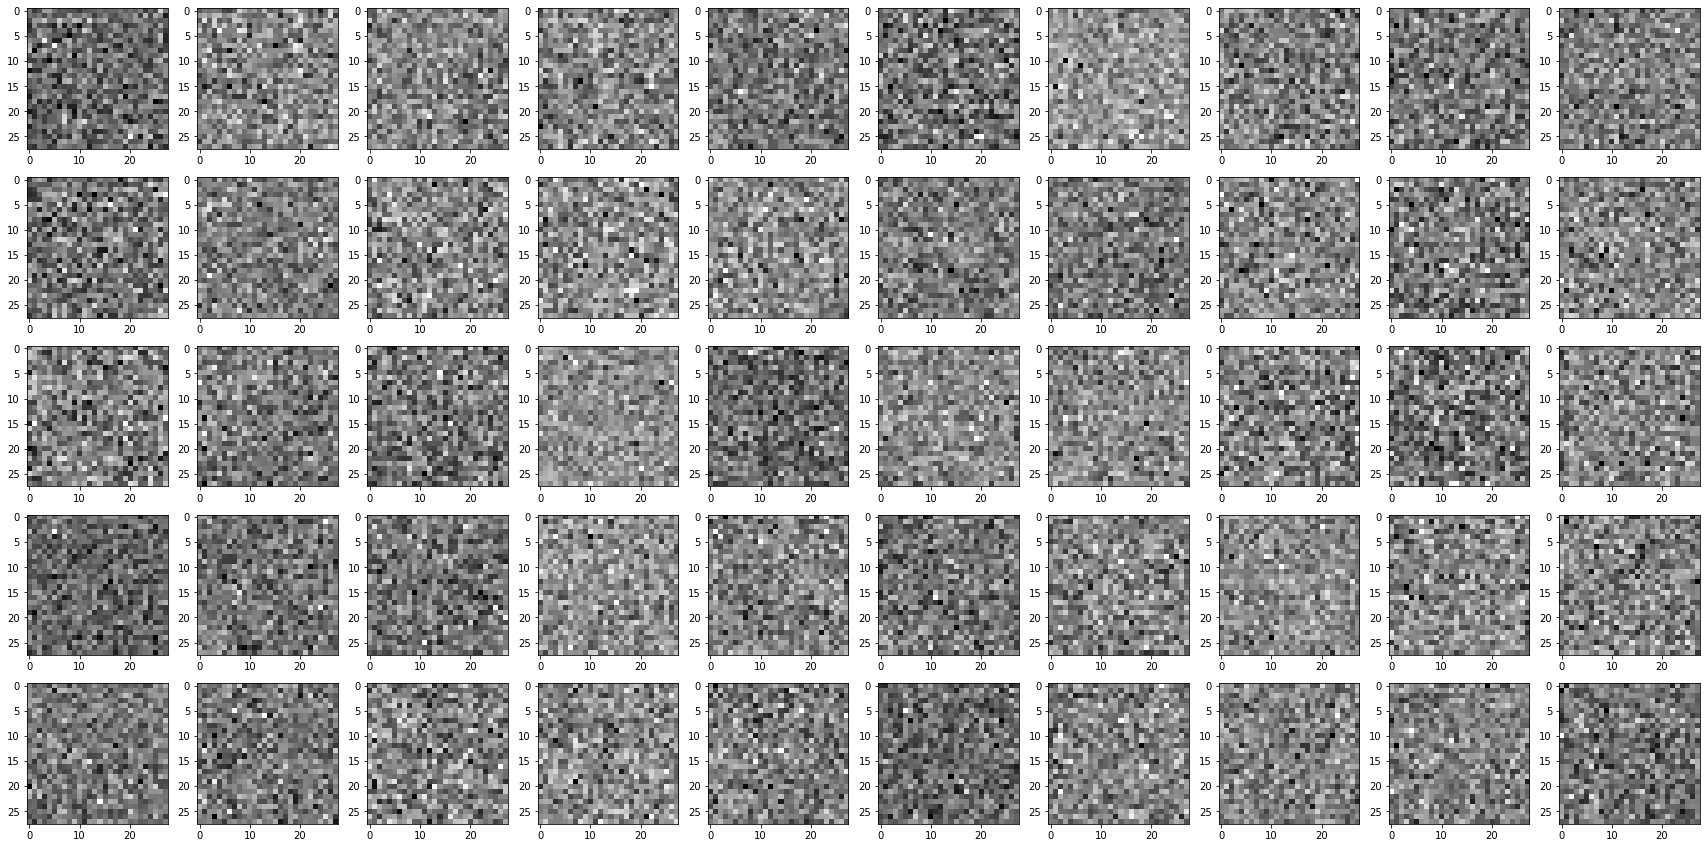

In [19]:
from matplotlib import pyplot as plt
import numpy as np


fig = plt.figure(figsize=(30, 15))
rows, cols = 5, 10

for row in range(rows):
    for col in range(cols):
        plt.subplot(rows, cols, rows*col+1+row)
        
        d = np.random.randn(1, 28, 28)*255
        d = d.transpose([1,2,0])
        plt.imshow(d.astype('int'), cmap='gray')
        
plt.show()